# Neural Networks with a Deep Learning Framework - PyTorch

1. In Practical9a.ipynb, we will first look at the same problem from the Practical 8 - classification of sklearn "moons".
2. Then, in Practical9b.ipynb, we will look at a far more complex problem of classification of hand-written numbers in the MNIST dataset.

Import libraries

In [18]:
%matplotlib inline  
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

__Load dataset__
- `train.csv` is a copy of the MNIST dataset (torchvision.datasets.MNIST()) that has been converted from image data to numerical CSV data

In [2]:
train = pd.read_csv(r"temp/input/train.csv",dtype = np.float32)

- Each row is an image
- The label represents the handwritten number
- pixel0 to pixel783 represent a 28x28 pixel image

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Pre-process the data for ingest into the model__
- split data into features (pixels) and labels (numbers from 0 to 9)

In [11]:
np_targets = train.label.values
np_features = train.loc[:,train.columns != "label"].values

Normalise the features (256 colour images)

In [12]:
print(np_features[np.where(np_features != 0)])
np_features /= 255

[188. 255.  94. ...  74. 250.  59.]


In [13]:
np_features[np.where(np_features != 0)]

array([0.7372549 , 1.        , 0.36862746, ..., 0.2901961 , 0.98039216,
       0.23137255], dtype=float32)

Split into 80:20 train:test sets

In [14]:
np_features_train, np_features_test, np_targets_train, np_targets_test = train_test_split(np_features,
                                                                                          np_targets,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

Convert to torch.Tensor
- note we can convert from float32 used by default in the numpy arrays to torch datatypes

In [15]:
features_train = torch.from_numpy(np_features_train)
targets_train = torch.from_numpy(np_targets_train).type(torch.LongTensor)

features_test = torch.from_numpy(np_features_test)
targets_test = torch.from_numpy(np_targets_test).type(torch.LongTensor)

In [16]:
features_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

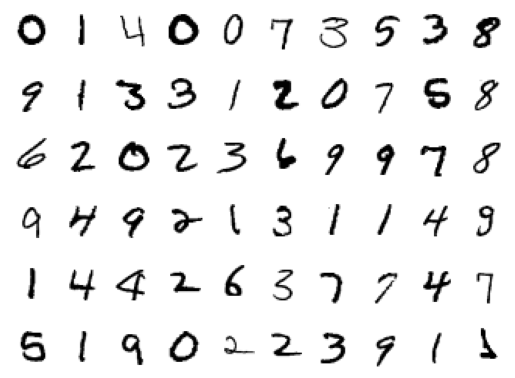

In [23]:
# visualize some images
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(np_features[index].reshape((28,28)), cmap='gray_r')
plt.show()

At this stage we have torch.Tensor object representing our data.

Now, we need to construct 
- torch.autograd.Variable objects - these will store our tensors and gradients
- torch.utils.data.DataLoader objects - these will provide the funcionality required to divide our images into batches

This is also a useful stage to decide on hyperparameters, since one of them, `batch_size`, is required on DataLoader initialisation.

In [24]:
# Combine feature and target combinations into train and test sets 
train = torch.utils.data.TensorDataset(features_train,targets_train)
test = torch.utils.data.TensorDataset(features_test,targets_test)

In [25]:
# some hyperparameters
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)


In [26]:
# initialise DataLoader objects
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

__Now build a Logistic Regression model__

As we saw in Practical 9a, a model is defined as a Python class extending nn.Module

In [29]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features, n_outputs):
        # initialise with Python super()
        super(LogisticRegressionModel, self).__init__()
        # linear regression activation
        self.linear = nn.Linear(n_features, n_outputs)
    
    def forward(self, x):
        return self.linear(x)



And that's it!!

But something is strange - the activation function is linear regression, not logistic regression...

The logistic part is taken care of y the loss function, which will use `nn.CrossEntropyLoss()` as its error:

In [27]:
# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

Instantiate the model

In [30]:
n_features = 784 # number of pixels per image
n_outputs = 10  # number of possible labes (0-9)

model = LogisticRegressionModel(n_features, n_outputs)
model

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Before jumping into making a neural network, let's look at PyTorch Tensors

- __Tensors__
    - Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing. 
    - To aid usability for those used to using NumPY, PyTorch adopt a similar API.

Let's look at creating NumPy arrays and PyTorch Tensors and compare.

In [ ]:
# numpy array construction from a Python list
my_list = [[1,2,3],[4,5,6]]
first_array = np.array(my_list) # 2x3 array
print("Array Type: {}".format(type(first_array))) # type
print("Array Shape: {}".format(np.shape(first_array))) # shape
print(first_array)

In [ ]:
# pytorch Tensor construction from a Python list
tensor = torch.Tensor(my_list)
print("Array Type: {}".format(tensor.type)) # type
print("Array Shape: {}".format(tensor.shape)) # shape
print(tensor)

In [ ]:
# empty arrays and Tensors are equivalent
print('numpy ones')
print(np.empty((2,3)))

print('pytorch ones')
print(torch.empty((2,3)))

In [ ]:
# arrays and Tensors of ones are equivalent
print('numpy ones')
print(np.ones((2,3)))

print('pytorch ones')
print(torch.ones((2,3)))

In [ ]:
# arrays and Tensors of random numbers are equivalent
print('numpy random')
print(np.random.rand(2,3)) # not fewer parentheses here - `np.random.rand()` takes two integers as inputs, whereas `np.ones()` takes a shape tuple

print('pytorch ones')
print(torch.rand((2,3)))

We can also convert between NumPy arrays and PyTorch Tensors

In [ ]:
# from numpy to tensor
array = np.array([[1,2,3],[4,5,6]])
print(type(array))
print(array)
tensor = torch.from_numpy(array)
print(type(tensor))
print(tensor)

# from tensor to numpy
array2 = tensor.numpy()
print(type(array2))
print(array2)

In [ ]:
# Finally, we often need to see the shape of an array or tensor
print(array.shape)
print(tensor.shape)

# Building a neural network - `tensor`, `autograd`, `torch.nn`, `forward()` and `backward()`

## Neural Networks


Neural networks can be constructed using the `torch.nn` package.

- `nn` depends on `autograd` to define models and differentiate them ())producing gradients).
- An `nn.Module` contains layers, and a method `forward(input)` that
returns the `output`.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

### Define the network


Let’s define this network:

In [ ]:
class ANN(nn.Module): ## construct a class extending nn.Module
    
    def __init__(self, n_hidden):
        super(ANN, self).__init__()
        self.i_h = nn.Sequential(nn.Linear(2, n_hidden), nn.Sigmoid()) # input layer taking 2 features (x and y coordinates of a point) and producing n_hidden features
        self.h_o = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid()) # output layer taking n_hidden features and producing 1 feature (the classification)
        
    def forward(self, x): # produce output given input by using input and output layers
        h = self.i_h(x)
        output = self.h_o(h)
        return output
    
n_hidden = 30
net = ANN(n_hidden = n_hidden) # initialse an ANN object with n_hidden = 30 
print(net)

We have defined the `forward()` function. `autograd` will define the `backward()` function for us in the following steps.

To see the tensors for features, weights and biases of our layers, use `state_dict()`:

In [ ]:
print(net.state_dict())

With our nerual network setup, we now need a loss function.

`torch.nn` provides a number of predefined loss functions [https://pytorch.org/docs/stable/nn.html#loss-functions](), of which we will choose the Binary Cross-entropy.

In [ ]:
# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
target = torch.tensor(y, dtype=torch.float32).view(-1,1) # `torch.tensor.view()` is equivalent to np.reshape() - here we swap rows and columns to get y into the shape we need

y_output = net(X_tensor) # calculating y_output produces the predicted y values
loss_fn = nn.BCELoss(reduction="sum")
loss = loss_fn(y_output, target) # the loss is the difference between predicted and target values according to the loss function
print(loss)

## Backpropagation

To backpropagate:
- clear previous gradients in the neural network
- use `loss.backward()` to backpropagate the errors.

That's it!

In [ ]:
#note, running this cell more than once will raise a runtime error as loss.backward() should only be run once.
net.zero_grad()
print([p.grad for p in net.parameters()])
loss.backward()
print([p.grad for p in net.parameters()])

## Update weights - optimisation

- in the previous practical we defined a Stochastic Gradient Descent optimiser in NumPy
- with PyTorch, we will simply chose the optimiser from `torch.optim`
- in `torch.optim.SGD()` we provide the parameters of the model, the learning rate (lr) and the momentum
- for more reading on initialisation of lr and momentum, see [http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf]().

In [ ]:
optimiser = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.0)

- _Try printing the parameters of the model before an after making an optimisation step (`optimiser.step()`) to see the difference._

# Run the model optimisation

In [ ]:
%%time
n_hidden = 30
net = ANN(n_hidden = n_hidden)

# optimizer
lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# loss function
loss_fn = torch.nn.BCELoss(reduction="sum")

# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

# training
n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = net(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print("Iteration {}/{}, loss {:.4f}".format(epoch, n_epochs, loss.item()))

__Plot the resulting decision boundaries of the model__

__Can you understand each line of the cell below? - What is different now we are using PyTorch?__

In [ ]:
# plotting 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xx_tensor, yy_tensor = torch.tensor(xx, dtype=torch.float), torch.tensor(yy, dtype=torch.float)
Z = net(torch.stack([xx_tensor.flatten(), yy_tensor.flatten()], 1))
Z = Z.detach().numpy()
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)

## This was equivalent to the NumPy training in the previous practical in terms of the number of epochs, features, optimiser and loss function

## Did it perform more quickly?
Remember, PyTorch tensors are equivalent to NumPy arrays, but they can be used efficiently on GPUs - _should_ this optimisation run more quickly than the NumPy-based one?

## Now switch to a GPU node (instructions on Learn) - run the whole notebook again and see the time difference before moving on to Practical9b.ipynb